In [4]:
#@title { vertical-output: true, display-mode: "form" }
import pandas as pd
from datetime import datetime, timedelta

# read the latest CSV file
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

# select 2 columns, rename, and parse the date
df = df.rename(columns={"data": 'day', "totale_casi": 'cases'})
df = df.loc[:, ['day', 'cases']]
first_day = datetime(2020, 1, 1) - timedelta(days=1)
df['day'] = df['day'].map(lambda x: (datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - first_day).days)

# the following block is just for displaying the input data, with some unused augmentation
dfG = df.copy()
dfG['cases_diff'] = dfG.diff()['cases']
dfG['cases_growth_%'] = round(dfG['cases_diff'] / (dfG['cases'] - dfG['cases_diff']) * 100, 1)
dfG['date'] = [first_day + timedelta(days = day) for day in dfG['day']]
print("...data for the last 7 days")
dfG[-7:]

...data for the last 7 days


,day,cases,cases_diff,cases_growth_%,date
18,73,17660,2547.0,16.9,2020-03-13
19,74,21157,3497.0,19.8,2020-03-14
20,75,24747,3590.0,17.0,2020-03-15
21,76,27980,3233.0,13.1,2020-03-16
22,77,31506,3526.0,12.6,2020-03-17
23,78,35713,4207.0,13.4,2020-03-18
24,79,41035,5322.0,14.9,2020-03-19


In [8]:
df

,day,cases
0,55,229
1,56,322
2,57,400
3,58,650
4,59,888
5,60,1128
6,61,1694
7,62,2036
8,63,2502
9,64,3089


In [5]:
#@title { vertical-output: true, display-mode: "form" }
import numpy as np
from scipy.optimize import curve_fit, fsolve
from IPython.display import HTML as html_print


def logistic_model(x, a, b, c):
    
    return c / (1 + np.exp(-(x - b) / a))  #Logistic
    return c / (1 + np.exp(-(x - b) / a))  #Exponent


# fit the data to the model (find the model variables that best approximate)
def predict_logistic_maximum(df):
    samples = df.shape[0]
    x_days = df['day'].tolist()
    y_cases = df['cases'].tolist()
    initial_guess = 4, 100, 25000 # speed, peak, amplitude

    fit = curve_fit(logistic_model, x_days, y_cases, p0=initial_guess, maxfev=9999)

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x (day of year) where the function reaches 99.99%
    end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples


# print results
def print_prediction(df, label):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    print(label + "'s prediction: " +
          "maximum cases: " + str(int(round(y_max))) +
          " (± " + str(int(round(y_max_error))) + ")" +
          ", peak at calendar day: " + str(int(round(x_peak))) +
          " (± " + str(round(x_peak_error, 2)) + ")" +
          ", ending on calendar day: " + str(end))
    return y_max


print_prediction(df[:-2], "2 days ago")
print_prediction(df[:-1], "yesterday")
pred = print_prediction(df, "today")
print()
html_print("As of today, the total infection should stabilize at <b>" + str(int(round(pred))) + "</b>")


2 days ago's prediction: maximum cases: 64710 (± 3394), peak at calendar day: 77 (± 0.42), ending on calendar day: 117
yesterday's prediction: maximum cases: 67488 (± 2713), peak at calendar day: 78 (± 0.34), ending on calendar day: 118
today's prediction: maximum cases: 77925 (± 3910), peak at calendar day: 79 (± 0.44), ending on calendar day: 121



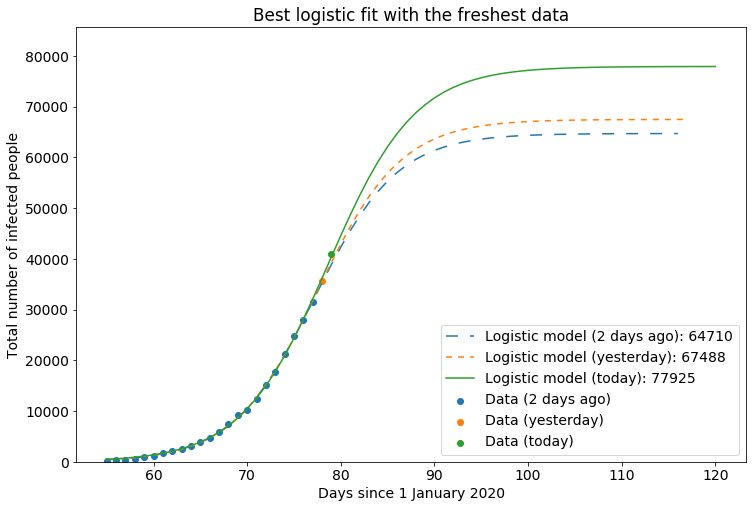

In [6]:
#@title { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as plt
plt.rc('font', size=14)


def add_real_data(df, label, color=None):
    x = df['day'].tolist()
    y = df['cases'].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)


def add_logistic_curve(df, label, **kwargs):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
             [logistic_model(i, speed, x_peak, y_max) for i in x_range],
             label="Logistic model (" + label + "): " + str(int(round(y_max))),
             **kwargs)
    return y_max


def label_and_show_plot(plt, title, y_max=None):
    plt.title(title)
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    if (y_max):
        plt.ylim(0, y_max * 1.1)
    plt.legend()
    plt.show()


# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:-1], "yesterday")
add_real_data(df[-1:], "today")
add_logistic_curve(df[:-2], "2 days ago", dashes=[8, 8])
add_logistic_curve(df[:-1], "yesterday", dashes=[4, 4])
y_max = add_logistic_curve(df, "today")
label_and_show_plot(plt, "Best logistic fit with the freshest data", y_max)